In [1]:
!pip install gym

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 144.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827634 sha256=12830b02a56299413e5bf79463d9142ac48474814a0e3af3f69665ea2e596b44
  Stored in directory: /tmp/pip-ephem-wheel-cache-cnsmk735/wheels/b9/22/6d/3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Successfully built gym


In [131]:
!tar -czf rl_notebook.tar.gz *

In [45]:
seed = 1234
results_action = 'load'# simulate, simulate_and_save or load

## Imports

In [46]:
import numpy as np
from rl.environments import GymEnvWrapper
from rl.plotting import plot_heatmap, plot_comparison, plot_best_alpha_comparison, plot_div_alpha_comparison, plot_parallel_comparison, plot_best_param_comparison, plot_best_and_div_alpha__comparison, plot_best_comparison, plot_simple_comparison
from rl.algorithms import nstepSARSA_rec, SARSAλ_tiling, comparison
from rl.value_functions import ActionValueFunctionTiling
from utils.results import save_results, load_results, flt
legend_best = {'borderaxespad': 0., 'frameon': False}
legend_top = {'bbox_to_anchor': (0., 1.02, 2., .102), 'loc': 'lower left', 'ncol': 5, 'mode':'expand', 'borderaxespad': 0.}
legend_top1 = {'bbox_to_anchor': (0., 1.02, 1., .102), 'loc': 'lower left', 'ncol': 5, 'mode':'expand', 'borderaxespad': 0.}
legend_top_2col = {'bbox_to_anchor': (0., 1.02, 1., .102), 'loc': 'lower left', 'ncol': 2, 'mode':'expand', 'borderaxespad': 0.}
legend_top_3col = {'bbox_to_anchor': (0., 1.02, 1., .102), 'loc': 'lower left', 'ncol': 3, 'mode':'expand', 'borderaxespad': 0.}
legend_top_4col = {'bbox_to_anchor': (0., 1.02, 1., .102), 'loc': 'lower left', 'ncol': 4, 'mode':'expand', 'borderaxespad': 0.}

## Environment

In [47]:
env_name = 'Acrobot'
env_n = 'Acrobot-v1'
# env_n = 'MountainCar-v0'
results_path = f'results/{env_name}/return'
environment = GymEnvWrapper
gamma = 1.0

## Results

### Control

In [48]:
algorithms = ['n-step SARSA', 'accumulate SARSA(λ)', 'replace SARSA(λ)', 'true online SARSA(λ)', 'accumulate SARSA-ET(λ)', 'replace SARSA-ET(λ)', 'true online SARSA-ET(λ)']
alg_colors = {algorithm_name: col for algorithm_name,col in zip(algorithms,['tab:green','goldenrod','orangered','tab:red','tab:cyan','tab:blue','tab:purple'])}
results = {algorithm_name: {'online': None, 'single-update': None} for algorithm_name in algorithms}

In [49]:
action_value_function = ActionValueFunctionTiling
num_tilings = 8
to_return = 'ep_return'
runs = 50
episodes = 50
operation = 'mean'
last = None
first = None
skip_first = False

#### Variables

In [50]:
epsilon = 0.0
max_steps = 500
initial_value = 0.0
alpha_strategy = 'fixed'
alpha_values = np.linspace(0.0, 1.4, 29)[1:]
beta = None
n_values = np.array([1,2,4,8,12,16,24,32])
lambda_values = np.array([0.0,0.2,0.4,0.6,0.7,0.8,0.85,0.9,0.92,0.95,0.98,1.0])
lines_filter = {
    'n': [True]*len(n_values),
    'λ': [True,False,True,True,False,True,False,True,True,True,False,True]#[True]*len(lambda_values)
}
processes = None
show_progress_bar = True
bar_desc = None
leave_bar = False
ylim = (-310.0,-180.0)

#### n-step SARSA

In [51]:
algorithm_name = 'n-step SARSA'
algorithm_function = nstepSARSA_rec
variable = 'n' 

In [52]:
# RTX 5000, alpha 28, n 8, 100 episodes 25 runs -> 2:23:22
# 2:23:22 RTX 5000, 50 episodes 50 runs, alpha linspace(0.0, 1.4, 29)[1:], n [1,2,4,8,12,16,24,32], 
single_update = False
file_name = f'{episodes}_{runs}_{env_n}_{num_tilings}_{algorithm_name}_online_{len(n_values)}_{epsilon:.2f}_{int(max_steps)}'
if 'simulate' in results_action:
    results[algorithm_name]['online'] = comparison(environment, algorithm_function, runs, episodes, alpha_values/num_tilings, n_values, epsilon, env_n, gamma, action_value_function, initial_value, num_tilings, alpha_strategy, max_steps, single_update, to_return, seed=seed, processes=processes, show_progress_bar=show_progress_bar, bar_desc=bar_desc, leave_bar=leave_bar)
    if 'save' in results_action:
        save_results(results_path, file_name, results[algorithm_name]['online'])
else:
    results[algorithm_name]['online'] = load_results(results_path, file_name)

In [53]:
np.max(flt(results[algorithm_name]['online'], operation, last, first, skip_first, lines_filter[variable]))

-229.1084

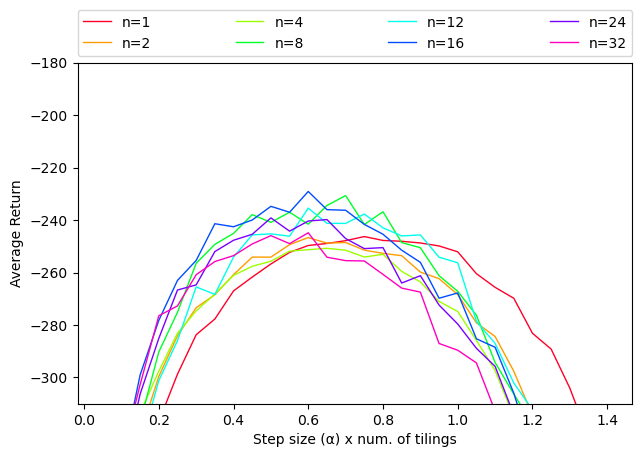

In [54]:
plot_comparison(flt(results[algorithm_name]['online'], operation, last, first, skip_first, lines_filter[variable]), n_values[lines_filter[variable]], alpha_values, variable, xlabel='Step size (α) x num. of tilings', ylabel='Average Return', ylim=ylim, legend_kwargs=legend_top_4col, save_file=f"results/{env_name}/plots/{env_name}_nstep")

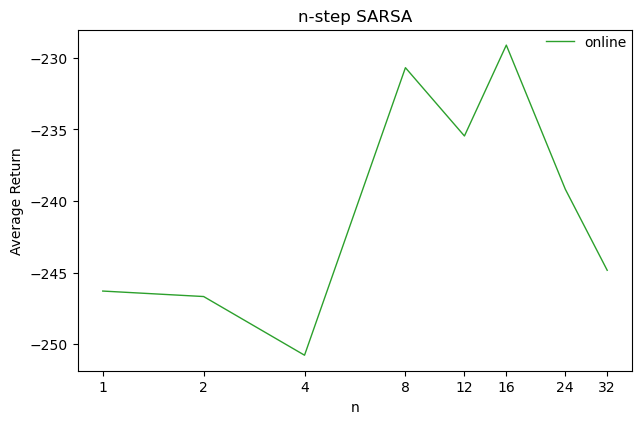

In [55]:
plot_best_alpha_comparison([flt(results[algorithm_name]['online'], operation, last, first, skip_first)], n_values, ['online'], algorithm_name, variable, ylabel="Average Return", _min = False, colors = [(alg_colors[algorithm_name],'solid'),(alg_colors[algorithm_name],'dashed')], log_scale = variable=='n', set_ticks=variable=='n', legend_kwargs=legend_best)

#### accumulate SARSA(λ)

In [56]:
algorithm_name = 'accumulate SARSA(λ)'
algorithm_function = SARSAλ_tiling
algorithm_type = 'accumulate'
variable = 'λ'

In [57]:
# RTX 5000, alpha 14, λ 12, 100 episodes 25 runs -> 2:10:25
# 4:01:30 A4000, 50 episodes 50 runs, alpha linspace(0.0, 1.4, 29)[1:], lambda_values [0.0,0.2,0.4,0.6,0.7,0.8,0.85,0.9,0.92,0.95,0.98,1.0]
single_update = False
file_name = f'{episodes}_{runs}_{env_n}_{num_tilings if num_tilings else 0}_{algorithm_name}_online_{len(lambda_values)}_{epsilon:.2f}_{int(max_steps)}'
if 'simulate' in results_action:
    results[algorithm_name]['online'] = comparison(environment, algorithm_function, runs, episodes, alpha_values/num_tilings, lambda_values, epsilon, env_n, algorithm_type, gamma, action_value_function, initial_value, num_tilings, alpha_strategy, max_steps, single_update, to_return, seed=seed, processes=processes, show_progress_bar=show_progress_bar, bar_desc=bar_desc, leave_bar=leave_bar)
    if 'save' in results_action:
        save_results(results_path, file_name, results[algorithm_name]['online'])
else:
    results[algorithm_name]['online'] = load_results(results_path, file_name)

In [58]:
np.max(flt(results[algorithm_name]['online'], operation, last, first, skip_first, lines_filter[variable]))

-230.6548

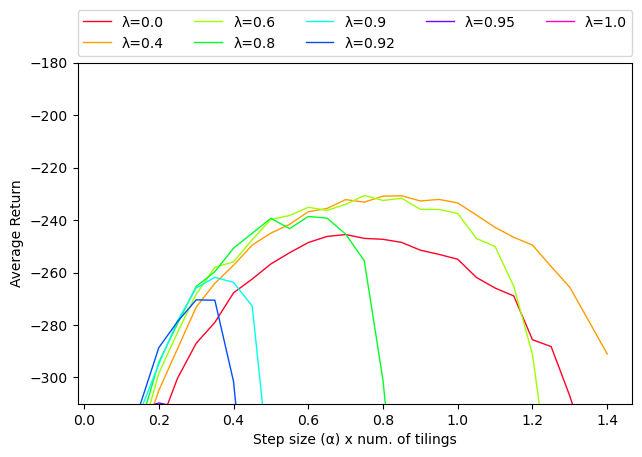

In [59]:
plot_comparison(flt(results[algorithm_name]['online'], operation, last, first, skip_first, lines_filter[variable]), lambda_values[lines_filter[variable]], alpha_values, variable, xlabel='Step size (α) x num. of tilings', ylabel='Average Return', ylim=ylim, legend_kwargs=legend_top1, save_file=None)

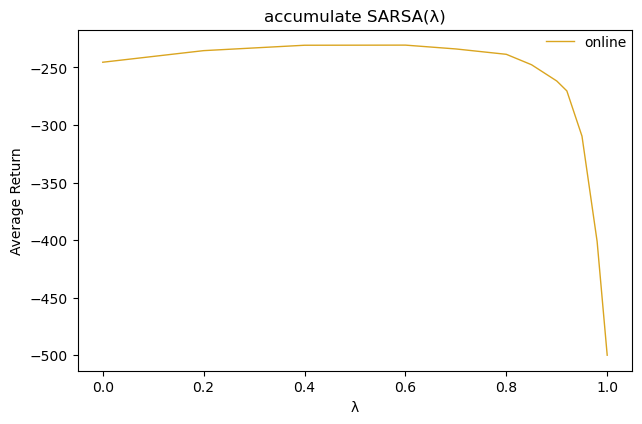

In [60]:
plot_best_alpha_comparison([flt(results[algorithm_name]['online'], operation, last, first, skip_first)], lambda_values, ['online'], algorithm_name, variable, ylabel="Average Return", _min = False, colors = [(alg_colors[algorithm_name],'solid'),(alg_colors[algorithm_name],'dashed')], log_scale = variable=='n', set_ticks=variable=='n', legend_kwargs=legend_best)

#### replace SARSA(λ)

In [61]:
algorithm_name = 'replace SARSA(λ)'
algorithm_function = SARSAλ_tiling
algorithm_type = 'replace'
variable = 'λ'

In [62]:
# 2:36:41 (RTX4000) - 50 runs 100 episodes - np.linspace(0.1, 1.4, 14) - np.array([0.0,0.4,0.8,0.9,0.92,0.95,0.98,1.0])
# 5:30:00 A4000, 50 episodes 50 runs, alpha linspace(0.0, 1.4, 29)[1:], lambda_values [0.0,0.2,0.4,0.6,0.7,0.8,0.85,0.9,0.92,0.95,0.98,1.0]
single_update = False
file_name = f'{episodes}_{runs}_{env_n}_{num_tilings if num_tilings else 0}_{algorithm_name}_online_{len(lambda_values)}_{epsilon:.2f}_{int(max_steps)}'
if 'simulate' in results_action:
    results[algorithm_name]['online'] = comparison(environment, algorithm_function, runs, episodes, alpha_values/num_tilings, lambda_values, epsilon, env_n, algorithm_type, gamma, action_value_function, initial_value, num_tilings, alpha_strategy, max_steps, single_update, to_return, seed=seed, processes=processes, show_progress_bar=show_progress_bar, bar_desc=bar_desc, leave_bar=leave_bar)
    if 'save' in results_action:
        save_results(results_path, file_name, results[algorithm_name]['online'])
else:
    results[algorithm_name]['online'] = load_results(results_path, file_name)

In [63]:
np.max(flt(results[algorithm_name]['online'], operation, last, first, skip_first, lines_filter[variable]))

-202.2864

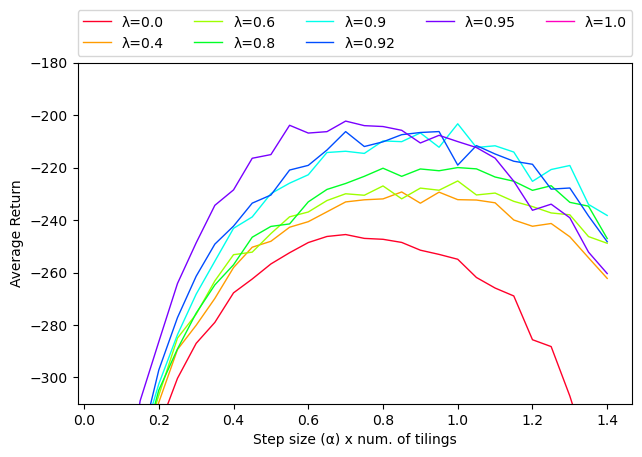

In [64]:
plot_comparison(flt(results[algorithm_name]['online'], operation, last, first, skip_first, lines_filter[variable]), lambda_values[lines_filter[variable]], alpha_values, variable, xlabel='Step size (α) x num. of tilings', ylabel='Average Return', ylim=ylim, legend_kwargs=legend_top1, save_file=None)

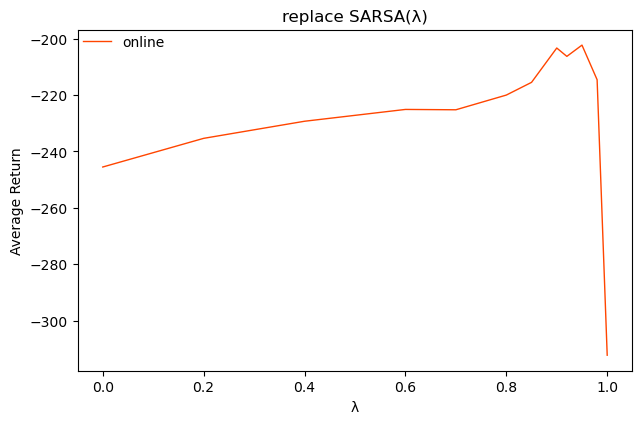

In [65]:
plot_best_alpha_comparison([flt(results[algorithm_name]['online'], operation, last, first, skip_first)], lambda_values, ['online'], algorithm_name, variable, ylabel="Average Return", _min = False, colors = [(alg_colors[algorithm_name],'solid'),(alg_colors[algorithm_name],'dashed')], log_scale = variable=='n', set_ticks=variable=='n', legend_kwargs=legend_best)

#### true online SARSA(λ)

In [66]:
algorithm_name = 'true online SARSA(λ)'
algorithm_function = SARSAλ_tiling
algorithm_type = 'true_online'
variable = 'λ'

In [67]:
# 1:40:00 (A4000) 3:00:00 (RTX4000) - 50 runs 100 episodes - np.linspace(0.1, 1.4, 14) - np.array([0.0,0.4,0.8,0.9,0.92,0.95,0.98,1.0])
# 5:00:00 A4000, 50 episodes 50 runs, alpha linspace(0.0, 1.4, 29)[1:], lambda_values [0.0,0.2,0.4,0.6,0.7,0.8,0.85,0.9,0.92,0.95,0.98,1.0]
single_update = False
file_name = f'{episodes}_{runs}_{env_n}_{num_tilings if num_tilings else 0}_{algorithm_name}_online_{len(lambda_values)}_{epsilon:.2f}_{int(max_steps)}'
if 'simulate' in results_action:
    results[algorithm_name]['online'] = comparison(environment, algorithm_function, runs, episodes, alpha_values/num_tilings, lambda_values, epsilon, env_n, algorithm_type, gamma, action_value_function, initial_value, num_tilings, alpha_strategy, max_steps, single_update, to_return, seed=seed, processes=processes, show_progress_bar=show_progress_bar, bar_desc=bar_desc, leave_bar=leave_bar)
    if 'save' in results_action:
        save_results(results_path, file_name, results[algorithm_name]['online'])
else:
    results[algorithm_name]['online'] = load_results(results_path, file_name)

In [68]:
np.max(flt(results[algorithm_name]['online'], operation, last, first, skip_first, lines_filter[variable]))

-194.83120000000002

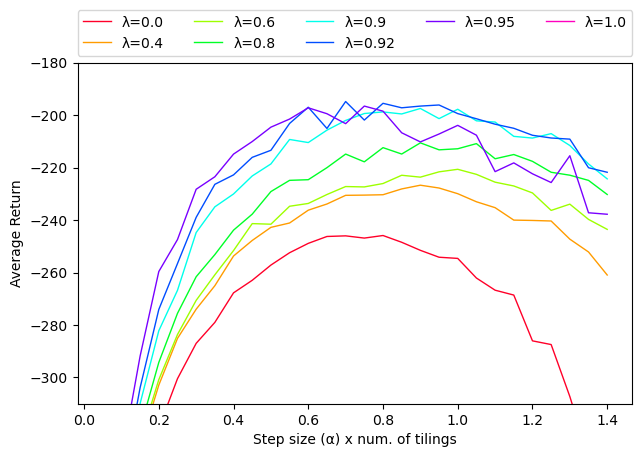

In [69]:
plot_comparison(flt(results[algorithm_name]['online'], operation, last, first, skip_first, lines_filter[variable]), lambda_values[lines_filter[variable]], alpha_values, variable, xlabel='Step size (α) x num. of tilings', ylabel='Average Return', ylim=ylim, legend_kwargs=legend_top1, save_file=None)

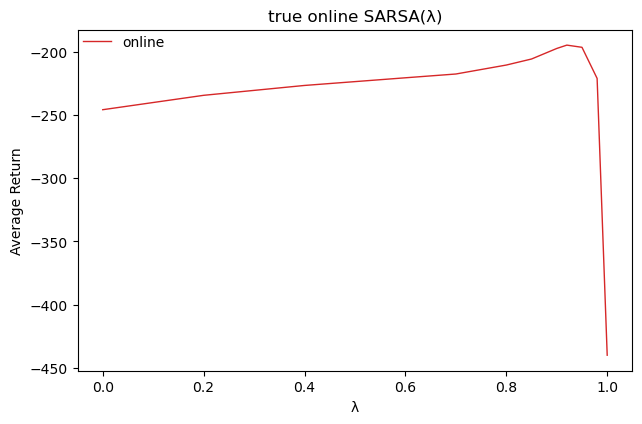

In [70]:
plot_best_alpha_comparison([flt(results[algorithm_name]['online'], operation, last, first, skip_first)], lambda_values, ['online'], algorithm_name, variable, ylabel="Average Return", _min = False, colors = [(alg_colors[algorithm_name],'solid'),(alg_colors[algorithm_name],'dashed')], log_scale = variable=='n', set_ticks=variable=='n', legend_kwargs=legend_best)

#### Comparison

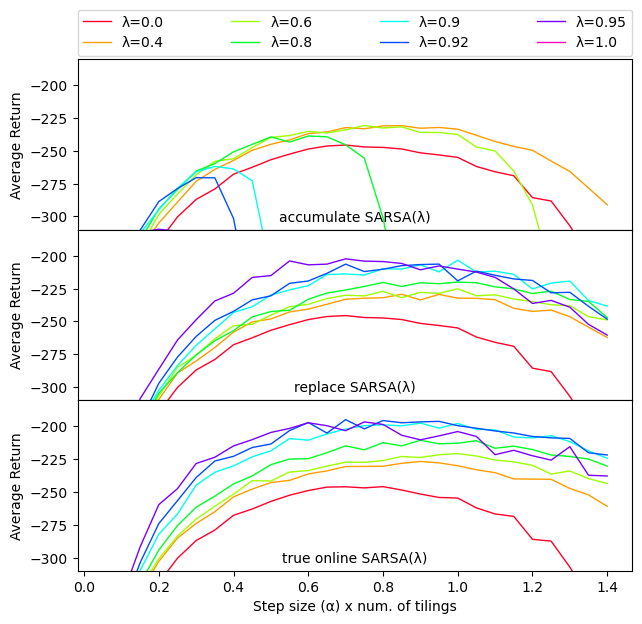

In [71]:
data_to_compare = [[('accumulate SARSA(λ)','online')], [('replace SARSA(λ)','online')], [('true online SARSA(λ)','online')]]
plot_parallel_comparison([[flt(results[a][t], operation, last, first, skip_first, lines_filter['λ']) for a,t in d] for d in data_to_compare], alpha_values, lambda_values[lines_filter['λ']], variable, [[f"{t+' ' if t=='single-update' else ''}{a}" for a,t in d] for d in data_to_compare], xlabel='Step size (α) x num. of tilings', ylabel="Average Return", ylim=ylim, legend_kwargs=legend_top_4col, save_file=f"results/{env_name}/plots/{env_name}_sarsa")

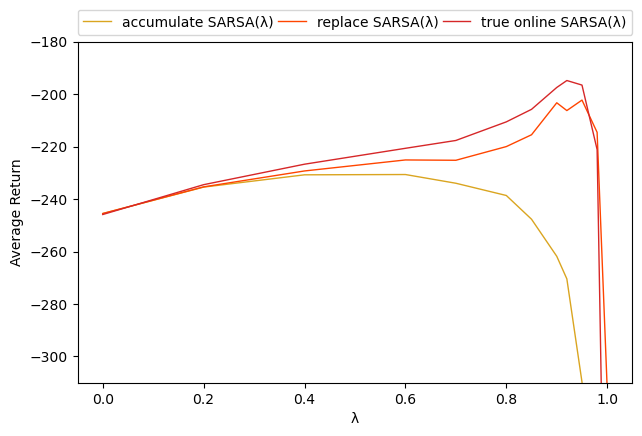

In [72]:
data_to_compare = [('accumulate SARSA(λ)','online'), ('replace SARSA(λ)','online'), ('true online SARSA(λ)','online')]
plot_best_alpha_comparison([flt(results[a][t], operation, last, first, skip_first) for a,t in data_to_compare], lambda_values, [f"{t+' ' if t=='single-update' else ''}{a}" for a,t in data_to_compare], None, variable, ylabel='Average Return', ylim=ylim, _min = False, colors = [(alg_colors[a],'dashed' if t=='single-update' else 'solid') for a,t in data_to_compare], log_scale = variable=='n', set_ticks=variable=='n', legend_kwargs=legend_top_3col, save_file=f"results/{env_name}/plots/{env_name}_sarsa_c")

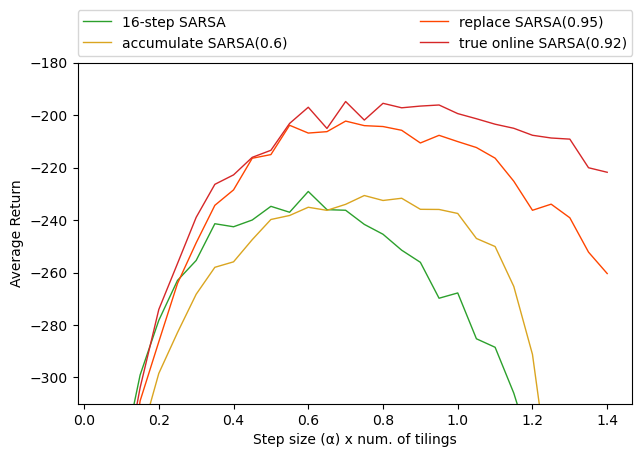

In [73]:
data_to_compare =[('n-step SARSA', 'online'), ('accumulate SARSA(λ)','online'), ('replace SARSA(λ)','online'), ('true online SARSA(λ)','online')]
plot_best_param_comparison([(lambda_values if 'λ' in a else n_values, flt(results[a][t], operation, last, first, skip_first)) for a,t in data_to_compare], alpha_values, [f"{t+' ' if t=='single-update' else ''}{a}".replace('λ', '{}').replace('n-step', '{}-step') for a,t in data_to_compare], None, _min=False, colors = [(alg_colors[a],'dashed' if t=='single-update' else 'solid') for a,t in data_to_compare], xlabel='Step size (α) x num. of tilings', ylabel="Average Return", ylim=ylim, legend_kwargs=legend_top_2col, save_file=f"results/{env_name}/plots/{env_name}_best")

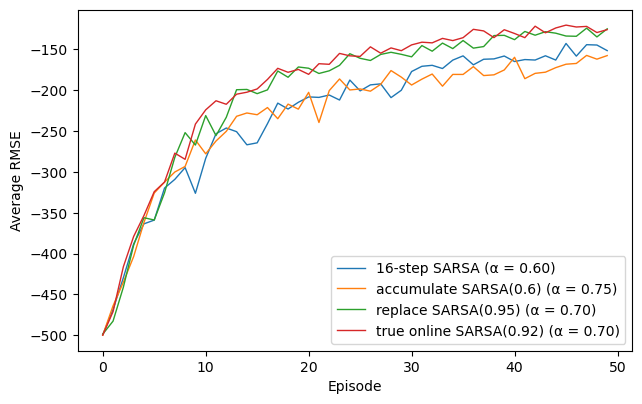

In [74]:
data_to_compare = [('n-step SARSA', 'online'), ('accumulate SARSA(λ)','online'), ('replace SARSA(λ)','online'), ('true online SARSA(λ)','online')]
plot_best_comparison(results, data_to_compare, alpha_values, lambda_values, n_values, operation, last, first, skip_first, _min = False)

### Effect of epsilon

In [75]:
runs = 250
episodes = 50
epsilon_values = np.linspace(0.0, 0.5, 6)

In [76]:
algorithm_name = 'true online SARSA(λ)'
algorithm_function = SARSAλ_tiling
algorithm_type = 'true_online'
variable = 'λ'
_lambda = 0.92
alpha = 0.9
file_name = f'{episodes}_{runs}_{env_n}_{num_tilings if num_tilings else 0}_{algorithm_name}_{_lambda:.2f}_{alpha:.2f}_{len(epsilon_values)}_eps'
if 'simulate' in results_action:
    results_eps = comparison_epsilon(environment, algorithm_function, runs, episodes, alpha/num_tilings, _lambda, epsilon_values, env_n, algorithm_type, gamma, action_value_function, initial_value, num_tilings, alpha_strategy, max_steps, single_update, to_return, seed=seed, processes=processes, show_progress_bar=show_progress_bar, bar_desc=bar_desc, leave_bar=leave_bar)
    if 'save' in results_action:
        save_results(results_path, file_name, results_eps)
else:
    results_eps = load_results(results_path, file_name)

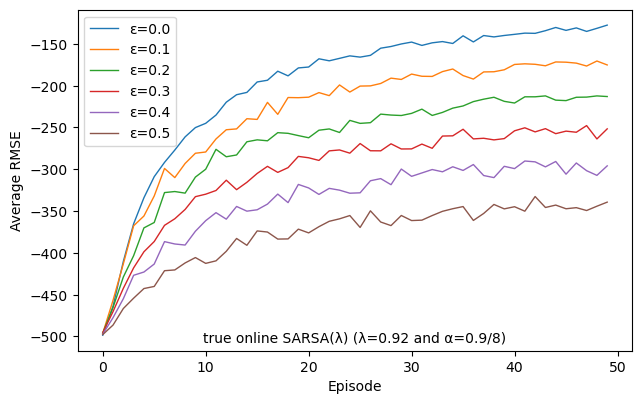

In [77]:
plot_simple_comparison(results_eps, [f"ε={e:.1f}" for e in epsilon_values], title=f"{algorithm_name} (λ={_lambda:.2f} and α={alpha:.1f}/{num_tilings})", save_file=f"results/{env_name}/plots/{env_name}_eps")